Keras (ja TensorFlow) perusteet
======================
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/11/TensorFlowLogo.svg/1229px-TensorFlowLogo.svg.png" 
alt="TensorFlow" width="400"/>
![Keras](https://upload.wikimedia.org/wikipedia/commons/c/c9/Keras_Logo.jpg "Keras")

Asentaaksesi tarvittavat paketit omalla koneellasi harjoituksen suorittamista varten:
```
$ pip3 install scikit-learn pandas tensorflow numpy matplotlib==2.2.2
```

## Keras
Nykyisellään TensorFlow suosittelee aloittelijoita lähtemään liikkeelle juuri [Keras](https://keras.io/)-API:n avulla. Keras sisältää kaksi hieman erityyppistä lähestymistapaa neuroverkkoihin: 
* [Sequential](https://keras.io/getting-started/sequential-model-guide/) on yksinkertaisempi, lineaarinen kasa neurotasoja. Tässä harjoituksessa keskitytään Sequential-API:in.
* [Functional](https://keras.io/getting-started/functional-api-guide/) mahdollistaa monmimutkaisempien mallien rakentamisen, muun muassa mahdollistamalla useampia syöte- ja tulostetasoja

Koska tässä harjoituksessa käytetään Kerasta TensoFlow:n kautta, Keras-dokumentaatiosta poiketen moduulien import-lauseet ovat hieman erilaiset. Esimerkiksi sen sijaan, että kirjoitettaisiin 
``` python
from keras.layers import Dense
layer = Dense(32, input_shape=(784,))
```
kirjoitetaankin
``` python
from tensorflow import keras
layer = keras.layers.Dense(32, input_shape=(784,))
```

## Yksinkertainen neuroverkko
Aluksi tehdään yksinkertainen luokittelu käyttäen hyväksi jo tutuksi tullutta [MNIST](https://en.wikipedia.org/wiki/MNIST_database)-aineistoa,joka sisältää käsinkirjoitettuja numeroita 0-9 kuvina. Lataa aineisto ja jaa se opetus- ja testijoukkoihin `X_train, X_test, y_train ja  y_test` siten, 
että testijoukon osuus on 20% ja opetusjoukon osuus on 80% havainnoista. Tällä kertaa käytä suoraan kuvia `dataset.images` äläkä yksiulotteisia havaintovektoreita `dataset.data`, sillä prosessointi tehdään myöhemmin.

In [31]:
# TODO: None
from sklearn import datasets
from sklearn.model_selection import train_test_split
dataset = datasets.load_digits()
X = dataset.images
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # TODO: None

Luo aluksi pelkkä [Sequential](https://keras.io/getting-started/sequential-model-guide/)-malli, johon myöhemmin lisätään tasoja `.add()`-metodilla.

In [32]:
from tensorflow import keras
# TODO: None
model = keras.models.Sequential()

Jotta mallin syötetaso ottaisi vastaan suoraan kaksiulotteisia kuvia, lisää malliin syötetaso, joka litistää havainnot yksiuloitteisiksi. Käytä tähän [Flatten](https://keras.io/layers/core/#flatten)-tasoa ja aseta sen `input_shape`-parametriksi pikseleiden koko. `input_shape`-parametria käytetään malleissa vain ensimmäisessä tasossa, jonka jälkeen malli osaa päätellä sen myöhemmissä tasoissa. Vinkki: saat yksittäisen kuvan koon selville `.shape`-metodilla.  

In [33]:
# TODO: None
# Lisää model-olioon taso
model.add(keras.layers.Flatten(input_shape=(8, 8)))

Seuraavaksi lisää [Dense](https://keras.io/layers/core/#Dense)-taso, joka on yksinkertainen halutun kokoinen neuraalotaso. Aseta tason kooksi 100 ja lisää sille aktivointifunktioksi `"relu"` `activation`-parametrin avulla. Katso lisätietoja [dokumentaatiosta](https://keras.io/activations/) 

In [34]:
# TODO: None
# Lisää model-olioon taso
model.add(keras.layers.Dense(100, activation="relu"))

Ylisovituksen estämiseksi malleille voi olla hyvä lisätä [Dropout](https://keras.io/layers/core/#dropout)-taso. Tämä taso muuttaa satunnaisesti tietyn prosenttiosuuden painotuksista nollaksi opetusiteraatioiden aikana. Aseta pudotuksen asteeksi 0.2.

In [35]:
# Lisää model-olioon taso
model.add(keras.layers.Dropout(0.2))

Mallille kerrottiin aluksi havaintojen koko `input_shape`-parametrilla ensimmäisessä tasossa. Samalla tavalla myös viimeisen tason haluttu koko on kerrottava mallille. Luokitteluongelmissa koko on tyypillisesti luokkien määrä. Painotukset halutaan kuitenkin muuttaa järkevästi tulkittaviksi, esimerkiksi todennäköisyysarvoiksi. Luokittelussa halutaan, että suurimman todennäköisyyden saanut luokka on luokittelutulos ja että kaikkien luokkien todennäköisyyslukemien summa olisi 1 jokaisella havainnolla. Tähän soveltuu mainiosti matemaattisesti [softmax](https://en.wikipedia.org/wiki/Softmax_function)-funktio.

Lisää siis viimeiseksi tasoksi [Dense](https://keras.io/layers/core/#Dense)-taso, sen kooksi haluttu luokkien lukumäärä ja sen aktivointifunktioksi `"softmax"`.

In [36]:
# Lisää model-olioon taso
model.add(keras.layers.Dense(10, activation="softmax"))

Malli on nyt valmis! Ennen opettamista malli täytyy vielä [koota](https://keras.io/models/sequential/#compile) (engl. compile) sopivan optimointifunktion ja häviöfunktion avulla. Käytetään tässä optimointifunktiona suosittua [`adam`](https://keras.io/optimizers/#adam)-funktiota.

Luokitteluongelman häviöfunktioksi sopii tyypillisesti joko [categorical_crossentropy](https://keras.io/losses/#categorical_crossentropy) tai [sparse_categorical_crossentropy](https://keras.io/losses/#sparse_categorical_crossentropy) riippuen siitä, missä muodossa data luokat ovat. Tähän asti luokat ovat olleet vain yksittäisiä numeroita. One-hot -koodaustapaa käytettäessä luokka ilmoitetaan eri tavalla indeksin avulla. Esimerkiksi aiemmin käytetyllä tavalla luokkien joukko [0, 2, 1] esitettäisiin one-hot -koodaustavalla:`[1 0 0],  [0 0 1], [0 1 0]`. One-hot pyrkii siis hävittämään  One-hot -koodaustavan tapauksessa `"categorical_crossentropy"` olisi soveltuva häviöfunktio, `"sparse_categorical_crossentropy"` taas sopii perinteiseen tapaan. 

Häviön lisäksi malli myös laskee metriikoita opetuksen edetessä. Tyypillisesti `"accuracy"`-metriikka riittää. Se kuvaa yleistä tarkkuutta OA.


In [85]:
# Kokoa model-olio
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               6500      
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 10)                1010      
Total params: 7,510
Trainable params: 7,510
Non-trainable params: 0
_________________________________________________________________
None


### Opettaminen
Mallin voi nyt opettaa. Tämä tehdään jo scikit-learn:ista tutulla `.fit()`-metodilla. Ylimääräiseksi parametriksi annetaan kuitenkin `epochs`, joka määrittää opetuksen keston koko opetusaineiston iteraatioina. Eli jos `epochs=10`, malli pääsee näkemään jokaisen opetusaineiston havainnon 10 kertaa opetuksen aikana. Liian suuri arvo voi johtaa ylisovitukseen ja liian pieni taas alisovitukseen. Valinnaisena parametrina voi antaa myös parametrin `batch_size`, eli erän koko. Erän koko kuva sitä kuinka kuinka monta havaintoa käsitellään kerrallaan. Siinä taas liian pieni arvo johtaa hitaaseen oppimiseen ja liian suuri taas voi johtaa alisovitukseen tai suorituskykyongelmiin.

Mallin opettaminen tulostaa ruudulle jatkuvasti häviön ja tarkkuuden arvoa. Nämä kuvaavat siis kyseisen epookin sisällä opetusjoukon sisäistä häviötä ja tarkkuutta. Mitä pienempi häviö ja mitä suurempi tarkkuus, niin sitä parempi malli pitäisi olla. Kuitenkin näitä arvoja ei pidä sekoittaa testausaineistolla tehtävään evaluointiin ja vasta opetuksen jälkeinen evaluointi kertoo mallin kyvystä yleistyä ongelmaan.Jos näyttää siltä, ettei häviö pienene epookkien välillä, epookkeja saattaa olla liikaa.


Opeta malli opetusjoukolla käyttäen 5 epookkia ja erän kokona 50 havaintoa.

In [89]:
# Opeta model-olio
history = model.fit(X_train, y_train, epochs=5, batch_size=50)

Epoch 1/5
1437/1437 [==============================] - 1s 963us/sample - loss: 0.3897 - acc: 0.8685
Epoch 2/5
1437/1437 [==============================] - 0s 180us/sample - loss: 0.2901 - acc: 0.9047
Epoch 3/5
1437/1437 [==============================] - 0s 145us/sample - loss: 0.2699 - acc: 0.9081
Epoch 4/5
1437/1437 [==============================] - 0s 204us/sample - loss: 0.2209 - acc: 0.9276
Epoch 5/5
1437/1437 [==============================] - 0s 142us/sample - loss: 0.2129 - acc: 0.9269


Opettaminen palauttaa `history`-olion, jota voi analysoida.

In [103]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist

,loss,acc
epoch,,
0,0.389727,0.868476
1,0.290116,0.904662
2,0.269940,0.908142
3,0.220885,0.927627
4,0.212890,0.926931


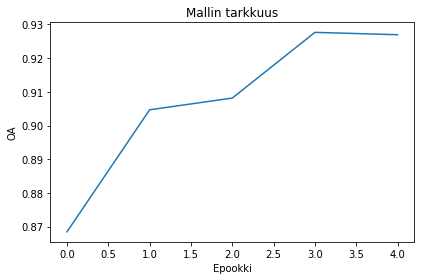

In [104]:
import matplotlib.pyplot as plt

plt.plot(hist["acc"])
plt.title('Mallin tarkkuus')
plt.ylabel('OA')
plt.xlabel('Epookki')
plt.show()

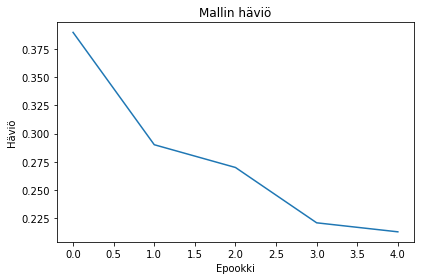

In [105]:
plt.plot(hist["loss"])
plt.title('Mallin häviö')
plt.ylabel('Häviö')
plt.xlabel('Epookki')
plt.show()

### Testaaminen
Mallin testaamiseksi voit käyttää `evaluate()`-metodia samaan tyyliin, kuin scikit-learn -luokittelijoissa `clf.score()`-funktiota.


In [44]:
# Evaluoi malli
evaluation = model.evaluate(X_test, y_test)
print("Testijoukon häviö: {:.4f} OA: {:.4f}".format(evaluation[0], evaluation[1]))

360/360 [==============================] - 0s 176us/sample - loss: 0.2298 - acc: 0.9222
Testijoukon häviö: 0.2298 OA: 0.9222


Voit myös käyttää scikit-learn -kirjaston evaluointitekniikoita. Muodosta aluksi `y_pred` aineisto mallin avulla käyttäen `.predict()`-metodia.

In [61]:
y_pred = model.predict(X_test)
print("Ensimmäinen alkio:", y_pred[0])

Ensimmäinen alkio: [1.05e-05 2.18e-06 7.23e-08 1.15e-06 1.24e-04 3.47e-06 9.99e-01 6.01e-07
 6.49e-04 2.17e-05]


Tarkastelemalla `y_pred`-oliota huomaat, että yksittäinen alkio onkin luokan sijasta lista todennäköisyyksiä. Ensimmäinen luku on luokan 0 todennäköisyys, toinen luku luokan 1 todennäköisyys ja niin edelleen. Luokitellun luokan saamiseksi on siis otettava suurimman todennäköisyyden saaneen indeksi. Tähän voi käyttää [`np.argmax()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html)-metodia.

In [62]:
import numpy as np
y_pred_probs = y_pred
y_pred = np.argmax(y_pred_probs, axis=1)
print("Suurimman todennäköisyyden saanut luokka: {}, sen saama todennäköisyys: {:.4f}".format(
    y_pred[0], y_pred_probs[0][y_pred[0]]))

Suurimman todennäköisyyden saanut luokka: 6, sen saama todennäköisyys: 0.9992


Muodosta luokitteluraportti ja sekaannusmatriisi.

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.87      0.93      0.90        28
           2       0.91      0.94      0.93        33
           3       0.97      0.88      0.92        34
           4       0.96      1.00      0.98        46
           5       0.93      0.87      0.90        47
           6       0.97      0.97      0.97        35
           7       0.92      0.97      0.94        34
           8       0.92      0.80      0.86        30
           9       0.82      0.90      0.86        40

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360



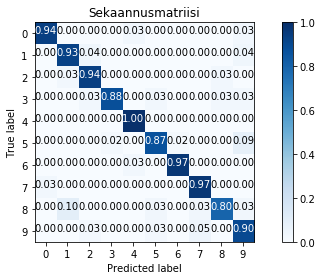

In [65]:
from sklearn.metrics import classification_report, confusion_matrix
from utils import plot_confusion_matrix

report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, list(range(10)), list(range(10)), normalize=True)
print(report)

## Mallin muokkaaminen
Kokeile seuraavaksi muokata mallia paremmaksi. Kopioi malli osa osalta alle `build_fn()`-funktion sisälle, jotta voit muuttaa parametreja helpommin. Käytä funktion parametreja ja voit lisätä omia parametreja muokkaamisen helpottamiseksi, mutta muist antaa niille oletusarvo. Voit lisätä malliin uusia (Dense-) tasoja ja voit muuttaa niiden kokoa ja poiston määrää. Muuta myös erien kokoa ja epookkien määriä. Älä kuitenkaan käytä liian isoja epookkilukuja (>20) tai neuronitasojen kokoja (>10000), jottei mallin opettaminen hidastu liikaa.

In [84]:
def build_fn(first_dense_units=100, dropout_rate=0.2):
    # Kopioi malli yllä olevista soluista koontivaiheeseen asti (model.compile())
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(8, 8)))
    model.add(keras.layers.Dense(first_dense_units, activation="relu"))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
model = build_fn(first_dense_units=100)
model.fit(X_train, y_train, epochs=5, batch_size=50)
evaluation = model.evaluate(X_test, y_test)
print("Testijoukon häviö: {:.4f} OA: {:.4f}".format(evaluation[0], evaluation[1]))

Epoch 1/5
1437/1437 [==============================] - 1s 785us/sample - loss: 5.5384 - acc: 0.2116
Epoch 2/5
1437/1437 [==============================] - 0s 203us/sample - loss: 1.7151 - acc: 0.5992
Epoch 3/5
1437/1437 [==============================] - 0s 163us/sample - loss: 0.7832 - acc: 0.7794
Epoch 4/5
1437/1437 [==============================] - 0s 150us/sample - loss: 0.5337 - acc: 0.8365
Epoch 5/5
360/360 [==============================] - 1s 2ms/sample - loss: 0.2234 - acc: 0.9167
Testijoukon häviö: 0.2234 OA: 0.9167


### Mallin tallentaminen
Kuten Scikit-learn:in tapauksessa, myös Keras-malleja voi tallentaa levylle. Neuroverkkojen opettaminen on usein hidasta puuhaa, mutta onneksi myös välituloksia opetuksessa voi tallentaa ja opetusta voi tarvittaessa jatkaa edellisestä kohdasta tallentamalla mallin painot.  

[Dokumentaation](https://keras.io/callbacks/#modelcheckpoint) perusteella luo `keras.callbacks.ModelCheckpoint`-funktio, joka tallentaa vain parhaat painot tiedostoon "keras-mnist-model-best-weights.ckpt"

In [86]:
checkpoint_location = "keras-mnist-model-best-weights.ckpt"

cp_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_location, verbose=1, save_weights_only=True, save_best=True)

model = build_fn()
model.fit(X_train, y_train, epochs=5, batch_size=50, callbacks = [cp_callback])
evaluation = model.evaluate(X_test, y_test)
print("Testijoukon häviö: {:.4f} OA: {:.4f}".format(evaluation[0], evaluation[1]))

Epoch 1/5
1400/1437 [============================>.] - ETA: 0s - loss: 5.1970 - acc: 0.2164
Epoch 00001: saving model to keras-mnist-model-best-weights.ckpt
1437/1437 [==============================] - 3s 2ms/sample - loss: 5.1094 - acc: 0.2234
Epoch 2/5
1350/1437 [===========================>..] - ETA: 0s - loss: 1.5972 - acc: 0.5726
Epoch 00002: saving model to keras-mnist-model-best-weights.ckpt
1437/1437 [==============================] - 0s 263us/sample - loss: 1.5514 - acc: 0.5825
Epoch 3/5
1400/1437 [============================>.] - ETA: 0s - loss: 0.8833 - acc: 0.7393
Epoch 00003: saving model to keras-mnist-model-best-weights.ckpt
1437/1437 [==============================] - 0s 225us/sample - loss: 0.8776 - acc: 0.7411
Epoch 4/5
1250/1437 [=========================>....] - ETA: 0s - loss: 0.6191 - acc: 0.7928
Epoch 00004: saving model to keras-mnist-model-best-weights.ckpt
1437/1437 [==============================] - 0s 281us/sample - loss: 0.6214 - acc: 0.7933
Epoch 5/5
1350

In [88]:
# Evaluoi tyhjää mallia
model = build_fn()
evaluation = model.evaluate(X_test, y_test)
print("Testijoukon häviö: {:.4f} OA: {:.4f}".format(evaluation[0], evaluation[1]))

# Evaluoi mallia painojen lataamisen jälkeen
model.load_weights(checkpoint_location)
evaluation = model.evaluate(X_test, y_test)
print("Testijoukon häviö: {:.4f} OA: {:.4f}".format(evaluation[0], evaluation[1]))

360/360 [==============================] - 1s 2ms/sample - loss: 10.7725 - acc: 0.0806
Testijoukon häviö: 10.7725 OA: 0.0806
360/360 [==============================] - 0s 196us/sample - loss: 0.2336 - acc: 0.9250
Testijoukon häviö: 0.2336 OA: 0.9250


Lue halutessasi lisää mallin tallentamisesta [täältä](https://www.tensorflow.org/tutorials/keras/save_and_restore_models).

## Scikit-learn yhteensopivuus
Äskeinen hyperparametrien optimointi saattoi tuntua aika manuaaliselta edellisten harjoitusten automatisoitujen keinojen jälkeen. Pystyisiköhän samoja menetelmiä käyttämään myös Keras-mallien kanssa? Kyllä [pystyy](https://keras.io/scikit-learn-api/)! Samoin Keras-mallin voi ottaa käyttöön laajemmassa Scikit-learn ympäristössä  ja siihen voi jopa soveltaa [putkitusta](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), mikä tuo paljon hyötyjä esimerkiksi datan esikäsittelyn (esim. standardtointi, pca) osalta.

Luo ensin `clf`-olio [dokumentaation](https://keras.io/scikit-learn-api/) avulla antamatta mitään muita parametreja, kuin `build_fn`.



In [81]:
# TODO: None
clf = keras.wrappers.scikit_learn.KerasClassifier(build_fn)

Luo sitten parametriverkko ja [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
. Luomasi `build_fn` parametrien lisäksi voit antaa parametreina myös opettamiseen tarvittavia parametreja, kuten `"epochs"` ja `"batch_size"`. Muista, että GridSearchCV käyttää ristivalidointia (CV=3 oletuksena), eli liian paljon eri aikaavieviä parametrikokeiluja ei kannata tehdä kerralla.

In [82]:
from sklearn.model_selection import GridSearchCV
parameters = {"first_dense_units": [1,10,100], "epochs": [1, 5]}
clf = GridSearchCV(clf, parameters)
clf.fit(X_train, y_train)
print("Parhaat parametrit: ", clf.best_params_)
print("Paras opetus OA: {:.4f}".format(clf.best_score_))
print("OA: {:.4f}".format(clf.score(X_test, y_test)))

/home/joona/IdeaProjects/MLCourse/venv/forNb/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


479/479 [==============================] - 1s 1ms/sample - loss: 1.7349 - acc: 0.6180
Epoch 1/5
958/958 [==============================] - 1s 916us/sample - loss: 2.4499 - acc: 0.0772
Epoch 2/5
958/958 [==============================] - 0s 189us/sample - loss: 2.3277 - acc: 0.1106
Epoch 3/5
958/958 [==============================] - 0s 215us/sample - loss: 2.2902 - acc: 0.1075
Epoch 4/5
958/958 [==============================] - 0s 273us/sample - loss: 2.2858 - acc: 0.1075
Epoch 5/5
479/479 [==============================] - 0s 1ms/sample - loss: 2.2763 - acc: 0.1148
Epoch 1/5
958/958 [==============================] - 1s 1ms/sample - loss: 4.3025 - acc: 0.0846
Epoch 2/5
958/958 [==============================] - 0s 252us/sample - loss: 2.5795 - acc: 0.1065
Epoch 3/5
958/958 [==============================] - 0s 284us/sample - loss: 2.3829 - acc: 0.1044
Epoch 4/5
958/958 [==============================] - 0s 243us/sample - loss: 2.3413 - acc: 0.1065
Epoch 5/5
479/479 [=================

## Lisenssi
Osa tämän harjoituksen esimerkeistä on muokattu sivun https://www.tensorflow.org/tutorials esimerkeistä.


In [25]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.